In [6]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.7 MB 1.6 MB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.7 MB 2.2 MB/s eta 0:00:01
   ------ --------------------------------- 0.3/1.7 MB 1.6 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.7 MB 1.4 MB/s eta 0:00:01
   --------- ------------------------------ 0.4/1.7 MB 1.3 MB/s eta 0:00:01
   ----------- ---------------------------- 0.5/1.7 MB 1.3 MB/s eta 0:00:01
   ------------ --------------------------- 0.6/1.7 MB 1.3 MB/s eta 0:00:01
   ------------- -------------------------- 0.6/1.7 MB 1.3 MB/s eta 0:00:01
   --------------- ------------------------ 0.7/1.7 MB 1.3 MB/s eta 0:00:01
   ---------------- ----------------------- 0.7/1.7 MB 1.3 MB/s eta 0:00:01
   ----------------- ---------------------- 0.8/1.7 MB 1.3 MB/s eta 0:00:01
   ------------------- ---------------


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\Niyati Patil\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


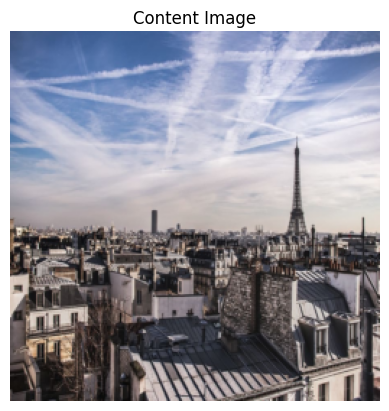

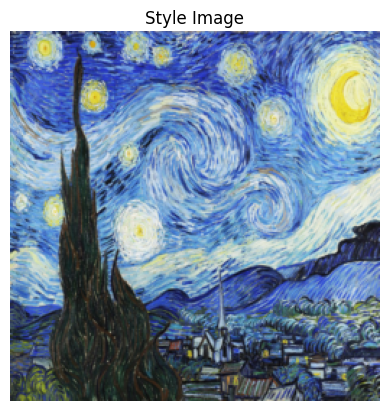

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\Niyati Patil/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|█████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:08<00:00, 1.76MB/s]


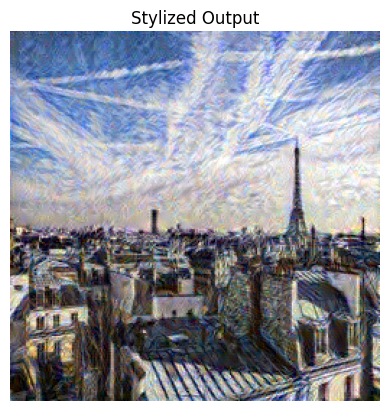

In [1]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load and preprocess image
def load_image(img_path, size=256):
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])
    return transform(image).unsqueeze(0)

# Gram matrix calculation
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G.div(c * h * w)

# Feature extraction using MobileNetV2
class FeatureExtractor(torch.nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1).features
        self.layers = layers

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.model):
            x = layer(x)
            if str(i) in self.layers:
                features.append(x)
        return features

# Load images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
content = load_image('base.jpg').to(device)
style = load_image('style.jpg').to(device)
target = content.clone().requires_grad_(True)

def imshow(tensor, title):
    img = tensor.squeeze().detach().cpu().permute(1, 2, 0).clamp(0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

imshow(content, "Content Image")
imshow(style, "Style Image")

# Extract features
extractor = FeatureExtractor(layers=['4', '7']).to(device).eval()

with torch.no_grad():
    style_features = extractor(style)
    content_features = extractor(content)
    style_grams = [gram_matrix(f) for f in style_features]

# Optimizer
optimizer = torch.optim.Adam([target], lr=0.01)

# Style Transfer loop
for step in range(200):
    target_features = extractor(target)
    content_loss = F.mse_loss(target_features[-1], content_features[-1])
    style_loss = sum(F.mse_loss(gram_matrix(f), g) for f, g in zip(target_features, style_grams))
    loss = content_loss + 1e5 * style_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Display output
output = target.squeeze().detach().cpu().clamp(0, 1).permute(1, 2, 0)
plt.imshow(output)
plt.axis('off')
plt.title("Stylized Output")
plt.show()
